### Практический проект курса  https://stepik.org/course/4852 

In [105]:
import pandas as pd
import numpy as np

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### Описание данных:

<br><b>events_train.csv </b> - данные о действиях, которые совершают студенты со стэпами

step_id - id стэпа
<br>user_id - анонимизированный id юзера
<br>timestamp - время наступления события в формате unix date
<br>action - событие, возможные значения: 
<br>discovered - пользователь перешел на стэп
<br>viewed - просмотр шага,
<br>started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
<br>passed - удачное решение практического шага



<b>submissions_train.csv</b> - данные о времени и статусах сабмитов к практическим заданиям

step_id - id стэпа
<br>timestamp - время отправки решения в формате unix date
<br>submission_status - статус решения
<br>user_id - анонимизированный id юзера

In [107]:
event_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [108]:
event_data.shape

(3480703, 4)

In [109]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [110]:
submissions_data.shape

(509104, 4)

In [111]:
# рейтинг пользователей по количеству отправленных решений
submissions_data.loc[submissions_data['submission_status'] == 'correct'].groupby('user_id').aggregate({'submission_status': 'count'}).sort_values(by='submission_status', ascending=False)

,submission_status
user_id,
1046,421
5552,186
17135,168
6183,142
8461,135
...,...
6191,1
6184,1
6166,1


In [112]:
event_data['date'] = pd.to_datetime(event_data['timestamp'], unit='s')

In [113]:
event_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [114]:
event_data['day'] = event_data['date'].dt.to_period('D')
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<Axes: xlabel='day'>

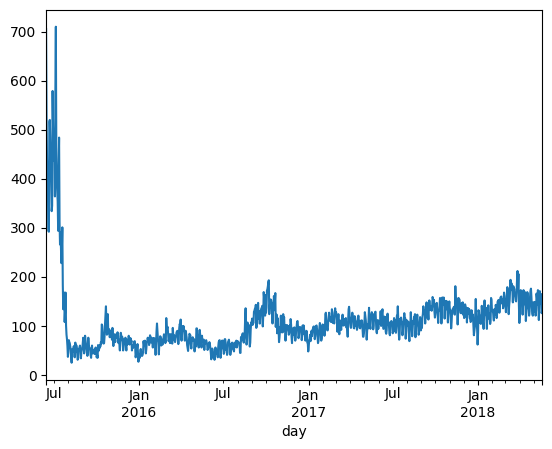

In [115]:
#количество уникальных пользователей на курсе по дням
event_data.groupby('day')['user_id'].nunique().plot()

In [116]:
#первые события на курсе
event_data.loc[event_data['timestamp'] == min(event_data['timestamp'])]

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15


In [117]:
min(event_data['timestamp'])

1434340848

In [167]:
submissions_data['date'] = pd.to_datetime(submissions_data['timestamp'], unit='s')
submissions_data['day'] = submissions_data['date'].dt.to_period('D')

In [168]:
users_scores = submissions_data.pivot_table(index='user_id',
                                            columns='submission_status',
                                            values= 'step_id',
                                            aggfunc= 'count',
                                            fill_value= 0
                                           ).rename_axis('index', axis="columns").reset_index()

users_scores.head()

index,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Что хотим посчитать?

1) Сколько уникальных степов прошел пользователь
2) Сколько правильных и сколько неправильных сабмитов решений
3) Сколько дней пользователь провел на курсе

Далее сравним эти результаты для пользователей которые закончили курс и которые бросили и выясним есть ли значимое раличие.

Кого считать бросившим курс?

In [169]:
# посчитаем промежутки между заходами на курс для пользователей

gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
            .groupby('user_id')['timestamp'].apply(list) \
            .apply(np.diff).values

<Axes: >

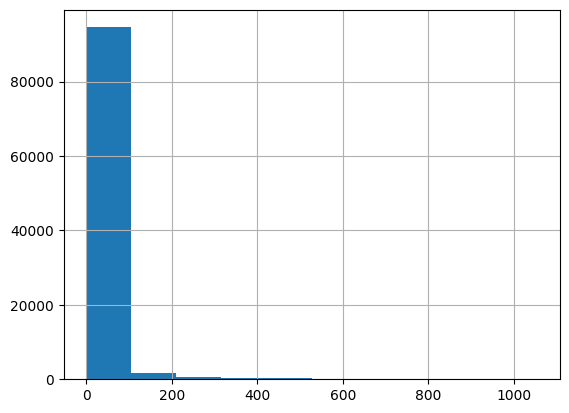

In [170]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60) #перевод из секунд в дни
gap_data.hist()

<Axes: >

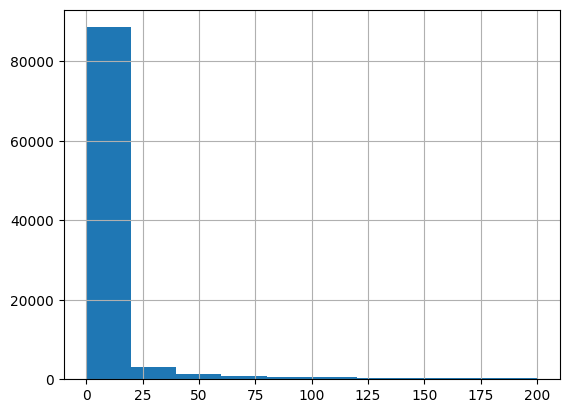

In [171]:
gap_data[gap_data < 200].hist()

In [172]:
# т.е. только 5% пользователей возвращается на курс после 60 дней перерыва (и более); 
# 10% возвращаются после перерыва 18 дней и более
gap_data.quantile(0.95) # 59.7 дней
gap_data.quantile(0.90) # 18.3 дней

18.325995370370403

In [173]:
#найти id автора курса, то есть пользователя который прорешал больше всего степов

new_df = submissions_data.pivot_table(index='user_id', columns='submission_status',values='step_id', aggfunc='count')

new_df[new_df['correct'] == new_df['correct'].max()]

submission_status,correct,wrong
user_id,,
1046,421.0,513.0


In [174]:
users_data = event_data.groupby('user_id', as_index=False)\
            .agg({"timestamp": "max"}).rename(columns={'timestamp': 'last_timestamp'})

In [175]:
#возьмем в качестве порогового значение 30 дней
drop_out_threshold = 30 * 24 * 60 * 60 #30 days in seconds

In [176]:
users_data['is_gone_user'] = (event_data['timestamp'].max() - users_data['last_timestamp']) > drop_out_threshold

In [177]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [178]:
user_events_data = event_data.pivot_table(index='user_id',
                                            columns='action',
                                            values= 'step_id',
                                            aggfunc= 'count',
                                            fill_value= 0
                                           ).reset_index()
user_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [179]:
users_data = users_data.merge(users_scores, how='outer', on='user_id')

In [180]:
users_data = users_data.fillna(0)

In [181]:
users_data = users_data.merge(user_events_data, how='outer', on='user_id')

In [182]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [183]:
#количество уникальных дней пользователя в приложении
users_day = event_data.groupby('user_id')['day'].nunique().to_frame().reset_index()

In [184]:
users_data = users_data.merge(users_day, how='outer')

In [185]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [186]:
users_data['passed_course'] = users_data['passed'] > 170

In [187]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [188]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [189]:
total_users = event_data['user_id'].nunique()
total_users

19234

In [190]:
100 * 1425 / total_users #процент прошедших курс "до конца" (прошедших 170 степов)

7.408755329104711

In [191]:
users_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

In [192]:
#проверка что при merge не потерялись пользователи
users_data.user_id.nunique()

19234

In [193]:
event_data.user_id.nunique()

19234

<Axes: >

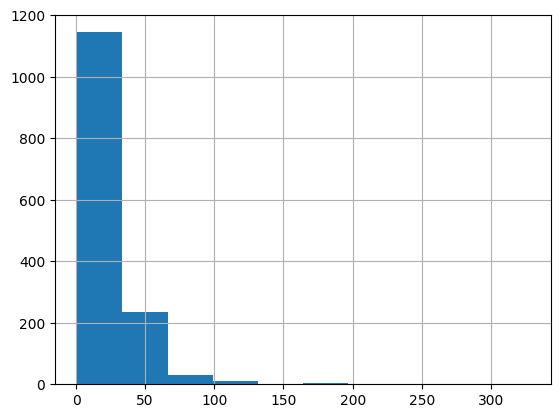

In [194]:
users_data[users_data['passed_course']]['day'].hist()

In [195]:
# половина пользователей (из тех что прошли курс до конца) проходит курс меньше чем за 20 дней
users_data[users_data['passed_course']]['day'].median()

20.0

Возьмем порог 3 дня - попытаемся по данным за первые 3 дня предсказать отвалится пользователь с курса или нет

Для начала отберем данные за первые три дня для каждого пользователя

In [196]:
# найдем timestamp первого действия на курсе для каждого пользователя

user_min_time = event_data.groupby('user_id') \
                .agg({'timestamp': 'min'}) \
                .rename({'timestamp': 'min_timestamp'}, axis=1).reset_index()

In [197]:
users_data = users_data.merge(user_min_time, how='outer', on='user_id')

In [198]:
learning_time_threshold = 3 * 24 * 60 * 60 # 3 дня в секундах

In [199]:
user_learning_time_threshold = user_min_time['user_id'].map(str) \
                                + '_' + (user_min_time['min_timestamp'] + learning_time_threshold).map(str)
                                

In [200]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [201]:
event_data.shape

(3480703, 8)

In [202]:
event_data = event_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [203]:
event_data.shape

(3480703, 8)

In [204]:
event_data['user_time'] = event_data['user_id'].map(str) + '_' + event_data['timestamp'].map(str)

In [205]:
event_data_train = event_data[event_data['user_time'] <= event_data['user_learning_time_threshold']]

___________________

Задание

найти степ, который "отпугнул" максимальное количество студентов, используя данные submission_data 

Т.е. для каждого пользователя найдите такой шаг, который он не смог решить, и после этого не пытался решать другие шаги. Затем найдите id шага,  который стал финальной точкой практического обучения на курсе для максимального числа пользователей.  

In [206]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp,min_timestamp,user_learning_time_threshold,users_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1479734163,1434345977,15853_1434605177,3298
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1479734163,1434345977,15853_1434605177,2323
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,1479734163,1434345977,15853_1434605177,44506172
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,1479734163,1434345977,15853_1434605177,44506187
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1479734163,1434345977,15853_1434605177,2146


In [207]:
# найдем timestamp последнего действия на курсе для каждого пользователя

user_last_attempt = submissions_data.groupby('user_id') \
                .agg({'timestamp': 'max'}) \
                .rename({'timestamp': 'max_timestamp'}, axis=1).reset_index()

In [208]:
submissions_data = submissions_data.merge(user_last_attempt, how='left', on='user_id')

In [209]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp_x,min_timestamp,user_learning_time_threshold,users_time,max_timestamp_y
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1479734163,1434345977,15853_1434605177,3298,1479734163
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1479734163,1434345977,15853_1434605177,2323,1479734163
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,1479734163,1434345977,15853_1434605177,44506172,1479734163
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,1479734163,1434345977,15853_1434605177,44506187,1479734163
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1479734163,1434345977,15853_1434605177,2146,1479734163


In [210]:
submissions_data.shape

(509104, 11)

In [213]:
submissions_data = submissions_data.drop('max_timestamp_y', axis=1)

In [214]:
last_steps = submissions_data[(submissions_data['submission_status'] == 'wrong') & (submissions_data['timestamp'] == submissions_data['max_timestamp_x'])]

In [215]:
last_steps.groupby('step_id').agg({'timestamp': 'count'}).rename({'timestamp': 'users_count'}, axis=1).sort_values(by='users_count', ascending=False)

,users_count
step_id,
31978,154
32812,133
32031,97
32202,92
33481,78
...,...
33482,1
33686,1
33684,1


Ответ: step_id = 31978

____________

In [216]:
# проверяем что действительно отфильтровали 3 дня. 
# Получили значение 4 т.к. "задели" 4е сутки в нашей выборке
event_data_train.groupby('user_id')['day'].nunique().max()

4

In [218]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp_x,min_timestamp_x,user_learning_time_threshold_x,users_time,min_timestamp_y,user_learning_time_threshold_y
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1479734163,1434345977,15853_1434605177,3298,1434345977,15853_1434605177
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1479734163,1434345977,15853_1434605177,2323,1434345977,15853_1434605177
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,1479734163,1434345977,15853_1434605177,44506172,1434345977,15853_1434605177
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,1479734163,1434345977,15853_1434605177,44506187,1434345977,15853_1434605177
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1479734163,1434345977,15853_1434605177,2146,1434345977,15853_1434605177


In [217]:
#Добавляем в submissions_data время первого степа
submissions_data = submissions_data.merge(user_min_time, on='user_id', how='left')


KeyError: 'min_timestamp'

In [219]:
# Время от первого степа до последнего
submissions_data['users_time'] = submissions_data['timestamp'] - submissions_data['min_timestamp_x']
#Выбираем степы первых трёх дней
submissions_data_train = submissions_data[submissions_data.users_time <= 3*24*60*60]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [220]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp_x,min_timestamp_x,user_learning_time_threshold_x,users_time,min_timestamp_y,user_learning_time_threshold_y
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1479734163,1434345977,15853_1434605177,3298,1434345977,15853_1434605177
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1479734163,1434345977,15853_1434605177,2323,1434345977,15853_1434605177
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1479734163,1434345977,15853_1434605177,2146,1434345977,15853_1434605177
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1479734163,1434345977,15853_1434605177,2211,1434345977,15853_1434605177
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1479734163,1434345977,15853_1434605177,1394,1434345977,15853_1434605177


In [222]:
submissions_data_train = submissions_data_train.drop(['min_timestamp_y', 'user_learning_time_threshold_y'], axis=1)

In [223]:
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,max_timestamp_x,min_timestamp_x,user_learning_time_threshold_x,users_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1479734163,1434345977,15853_1434605177,3298
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1479734163,1434345977,15853_1434605177,2323
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1479734163,1434345977,15853_1434605177,2146
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1479734163,1434345977,15853_1434605177,2211
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1479734163,1434345977,15853_1434605177,1394
...,...,...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,1501946959,1501946660,2615_1502205860,299
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,1503059927,1503055287,13177_1503314487,4640
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,1506348153,1506347263,15253_1506606463,890
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1523035316,1523035269,1424_1523294469,47


In [256]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day': 'days'})

In [257]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id': 'steps_tried'})

In [258]:
X = X.merge(steps_tried, on='user_id', how='left')

In [259]:
X.shape

(8913, 3)

In [260]:
X.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


In [261]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                            columns='submission_status',
                                            values= 'step_id',
                                            aggfunc= 'count',
                                            fill_value= 0
                                           ).rename_axis('index', axis="columns").reset_index())
X.head()

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [262]:
# добавим колонку с долей верно решенных степов
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [263]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [264]:
X = X.merge(event_data_train.pivot_table(index='user_id',
                                            columns='action',
                                            values= 'step_id',
                                            aggfunc= 'count',
                                            fill_value= 0
                                           ).reset_index()[['user_id', 'viewed']], how='outer')

In [265]:
X = X.fillna(0)

In [266]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [267]:
X = X[~((X['is_gone_user'] == False) & (X['passed_course'] == False))]

In [268]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [269]:
y = X.passed_course.map(int)
X = X.drop(['passed_course', 'is_gone_user'], axis=1) # удаляем из features целевую переменную

In [270]:
X = X.set_index(X.user_id) # переносим user_id в индекс
X = X.drop('user_id', axis=1)

In [271]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
